
# LECTURE 12

## RNN


In [1]:
###-----------------
### Import Libraries
###-----------------;

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from collections.abc import Callable
from typing import Literal

from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, ConfusionMatrixDisplay
from sklearn.preprocessing import StandardScaler

%matplotlib inline

2023-11-30 12:56:19.218274: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-11-30 12:56:21.749094: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-11-30 12:56:21.749289: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-11-30 12:56:22.243102: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-11-30 12:56:22.842679: I tensorflow/core/platform/cpu_feature_guar

In [50]:
###----------------
### Some parameters
###----------------

inpDir = '../input'
outDir = '../output'

RANDOM_STATE = 24 # REMEMBER: to remove at the time of promotion to production
np.random.seed(RANDOM_STATE) # Set Random Seed for reproducible  results

EPOCHS = 200 # number of epochs
ALPHA = 0.01 # learning rate
NUM_SAMPLES = 1280 # How many samples we want to generate
NOISE = 0.2 # Noise to be introduced in the data
TEST_SIZE = 0.2
BATCH_SIZE = 32
TRAIN_SIZE = 14496

# parameters for Matplotlib
params = {'legend.fontsize': 'x-large',
          'figure.figsize': (15, 8),
          'axes.labelsize': 'x-large',
          'axes.titlesize':'x-large',
          'xtick.labelsize':'x-large',
          'ytick.labelsize':'x-large'
         }

CMAP = 'coolwarm' # plt.cm.Spectral

plt.rcParams.update(params)

## Helper Functions

In [3]:
###-----------------------------------
### Function to plot Decision boundary
###-----------------------------------

def fn_plot_decision_boundary(pred_func: Callable[[], np.float64], X_tr: np.ndarray, y_tr: np.ndarray, X_ts :  np.ndarray, y_ts:  np.ndarray,):
    '''
        Attrib:
           pred_func : function based on predict method of the classifier
           X_tr : train feature matrix
           y_tr : train labels
           X_ts : test feature matrix
           y_ts : test labels
       Return:
           None
    '''

    # Set min and max values and give it some padding
    xMin, xMax = X_tr[:, 0].min() - .05, X_tr[:, 0].max() + .05
    yMin, yMax = X_tr[:, 1].min() - .05, X_tr[:, 1].max() + .05

    # grid size for mesh grid
    h = 0.01

    # Generate a grid of points with distance 'h' between them
    xx, yy = np.meshgrid(np.arange(xMin, xMax, h), np.arange(yMin, yMax, h))

    # Predict the function value for the whole grid
    Z = pred_func(np.c_[xx.ravel(), yy.ravel()])

    # Make its shape same as that of xx
    Z = Z.reshape(xx.shape)

    fig = plt.figure()
    ax = fig.add_axes(111)

    # Now we have Z value corresponding to each of the combination of xx and yy
    # Plot the contour and training examples
    ax.contourf(xx, yy, Z, cmap=CMAP) #, alpha = 0.8

    # Plotting scatter for train data
    ax.scatter(X_tr[:, 0], X_tr[:, 1],
               c=np.argmax(y_tr, axis = 1), # y_tr has two columns
               s=30, edgecolor='k', cmap=plt.cm.coolwarm)


    # Plotting scatter for test data
    ax.scatter(X_ts[:, 0], X_ts[:, 1],
               c=np.argmax(y_ts, axis = 1), # y_tr has two columns ,
                                  s=150, marker = '*',edgecolor='k', cmap=plt.cm.inferno )


## Generate Data Set

In [23]:
data_df=pd.read_csv('weatherHistory.csv')

In [24]:
data_df

Formatted Date        Summary Precip Type  \
0      2006-04-01 00:00:00.000 +0200  Partly Cloudy        rain   
1      2006-04-01 01:00:00.000 +0200  Partly Cloudy        rain   
2      2006-04-01 02:00:00.000 +0200  Mostly Cloudy        rain   
3      2006-04-01 03:00:00.000 +0200  Partly Cloudy        rain   
4      2006-04-01 04:00:00.000 +0200  Mostly Cloudy        rain   
...                              ...            ...         ...   
96448  2016-09-09 19:00:00.000 +0200  Partly Cloudy        rain   
96449  2016-09-09 20:00:00.000 +0200  Partly Cloudy        rain   
96450  2016-09-09 21:00:00.000 +0200  Partly Cloudy        rain   
96451  2016-09-09 22:00:00.000 +0200  Partly Cloudy        rain   
96452  2016-09-09 23:00:00.000 +0200  Partly Cloudy        rain   

       Temperature (C)  Apparent Temperature (C)  Humidity  Wind Speed (km/h)  \
0             9.472222                  7.388889      0.89            14.1197   
1             9.355556                  7.227778      0.86            14.2646   
2             9.377778                  9.377778      0.89             3.9284   
3             8.288889                  5.944444      0.83            14.1036   
4             8.755556                  6.977778      0.83            11.0446   
...                ...                       ...       ...                ...   
96448        26.016667                 26.016667      0.43            10.9963   
96449        24.583333                 24.583333      0.48            10.0947   
96450        22.038889                 22.038889      0.56             8.9838   
96451        21.522222                 21.522222      0.60            10.5294   
96452        20.438889                 20.438889      0.61             5.8765   

       Wind Bearing (degrees)  Visibility (km)  Loud Cover  \
0                       251.0          15.8263         0.0   
1                       259.0          15.8263         0.0   
2                       204.0          14.9569         0.0   
3                       269.0          15.8263         0.0   
4                       259.0          15.8263         0.0   
...                       ...              ...         ...   
96448                    31.0          16.1000         0.0   
96449                    20.0          15.5526         0.0   
96450                    30.0          16.1000         0.0   
96451                    20.0          16.1000         0.0   
96452                    39.0          15.5204         0.0   

       Pressure (millibars)                           Daily Summary  
0                   1015.13       Partly cloudy throughout the day.  
1                   1015.63       Partly cloudy throughout the day.  
2                   1015.94       Partly cloudy throughout the day.  
3                   1016.41       Partly cloudy throughout the day.  
4                   1016.51       Partly cloudy throughout the day.  
...                     ...                                     ...  
96448               1014.36  Partly cloudy starting in the morning.  
96449               1015.16  Partly cloudy starting in the morning.  
96450               1015.66  Partly cloudy starting in the morning.  
96451               1015.95  Partly cloudy starting in the morning.  
96452               1016.16  Partly cloudy starting in the morning.  

[96453 rows x 12 columns]

In [25]:
data_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 96453 entries, 0 to 96452
Data columns (total 12 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Formatted Date            96453 non-null  object 
 1   Summary                   96453 non-null  object 
 2   Precip Type               95936 non-null  object 
 3   Temperature (C)           96453 non-null  float64
 4   Apparent Temperature (C)  96453 non-null  float64
 5   Humidity                  96453 non-null  float64
 6   Wind Speed (km/h)         96453 non-null  float64
 7   Wind Bearing (degrees)    96453 non-null  float64
 8   Visibility (km)           96453 non-null  float64
 9   Loud Cover                96453 non-null  float64
 10  Pressure (millibars)      96453 non-null  float64
 11  Daily Summary             96453 non-null  object 
dtypes: float64(8), object(4)
memory usage: 8.8+ MB


In [26]:
data_df['Time'] = pd.to_datetime(data_df['Formatted Date'],utc=True)

In [27]:
data_df.drop('Formatted Date',axis=1,inplace=True)

In [28]:
data_df.head()

Summary Precip Type  Temperature (C)  Apparent Temperature (C)  \
0  Partly Cloudy        rain         9.472222                  7.388889   
1  Partly Cloudy        rain         9.355556                  7.227778   
2  Mostly Cloudy        rain         9.377778                  9.377778   
3  Partly Cloudy        rain         8.288889                  5.944444   
4  Mostly Cloudy        rain         8.755556                  6.977778   

   Humidity  Wind Speed (km/h)  Wind Bearing (degrees)  Visibility (km)  \
0      0.89            14.1197                   251.0          15.8263   
1      0.86            14.2646                   259.0          15.8263   
2      0.89             3.9284                   204.0          14.9569   
3      0.83            14.1036                   269.0          15.8263   
4      0.83            11.0446                   259.0          15.8263   

   Loud Cover  Pressure (millibars)                      Daily Summary  \
0         0.0               1015.13  Partly cloudy throughout the day.   
1         0.0               1015.63  Partly cloudy throughout the day.   
2         0.0               1015.94  Partly cloudy throughout the day.   
3         0.0               1016.41  Partly cloudy throughout the day.   
4         0.0               1016.51  Partly cloudy throughout the day.   

                       Time  
0 2006-03-31 22:00:00+00:00  
1 2006-03-31 23:00:00+00:00  
2 2006-04-01 00:00:00+00:00  
3 2006-04-01 01:00:00+00:00  
4 2006-04-01 02:00:00+00:00

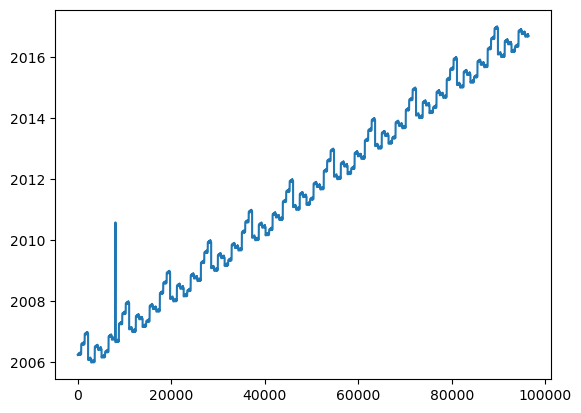

In [29]:
data_df['Time'].plot();

In [32]:
temp_df = data_df[['Time','Temperature (C)']]
temp_df = temp_df.sort_values('Time',axis=0,ascending=True)
temp_df = temp_df.reset_index(drop=True)
temp_df.head()

Time  Temperature (C)
0 2005-12-31 23:00:00+00:00         0.577778
1 2006-01-01 00:00:00+00:00         1.161111
2 2006-01-01 01:00:00+00:00         1.666667
3 2006-01-01 02:00:00+00:00         1.711111
4 2006-01-01 03:00:00+00:00         1.183333

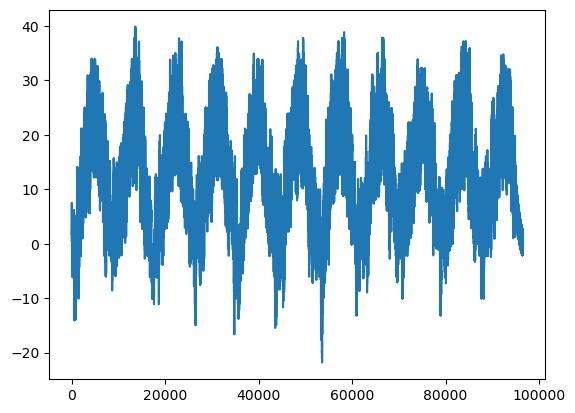

In [34]:
temp_df['Temperature (C)'].plot();

In [35]:
temp_df = temp_df.rename({'Temperature (C)': 'temp'}, axis=1)
temp_df.head()

Time      temp
0 2005-12-31 23:00:00+00:00  0.577778
1 2006-01-01 00:00:00+00:00  1.161111
2 2006-01-01 01:00:00+00:00  1.666667
3 2006-01-01 02:00:00+00:00  1.711111
4 2006-01-01 03:00:00+00:00  1.183333

In [36]:
temp_df.reset_index(drop=True, inplace = True)
temp_df.head()

Time      temp
0 2005-12-31 23:00:00+00:00  0.577778
1 2006-01-01 00:00:00+00:00  1.161111
2 2006-01-01 01:00:00+00:00  1.666667
3 2006-01-01 02:00:00+00:00  1.711111
4 2006-01-01 03:00:00+00:00  1.183333

In [37]:
temp_df.shape

(96453, 2)

### Prepare Model:

In [9]:
h_units=100

input_shape=(1,10000)

model = tf.keras.Sequential()

model.add(tf.keras.layers.SimpleRNN(units=h_units,
                                   input_shape=input_shape,
                                   activation='tanh'))

model.add(tf.keras.layers.Dense(units=1,
                               activation='linear'))

In [11]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn (SimpleRNN)      (None, 100)               1010100   
                                                                 
 dense (Dense)               (None, 1)                 101       
                                                                 
Total params: 1010201 (3.85 MB)
Trainable params: 1010201 (3.85 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [38]:
wax = model.get_weights()[0].shape
waa = model.get_weights()[1].shape
baa = model.get_weights()[2].shape
way = model.get_weights()[3].shape
bay = model.get_weights()[4].shape

print ('Shape of Matrix:')
print ('Wax = ', wax,'; Waa = ', waa, '; baa = ', baa,'; Way = ', way,'; bay = ', bay)

Shape of Matrix:
Wax =  (10000, 100) ; Waa =  (100, 100) ; baa =  (100,) ; Way =  (100, 1) ; bay =  (1,)


In [39]:
time_step = 24

In [40]:
y_idx = np.arange(time_step, temp_df.shape[0], time_step)
y_df = temp_df.iloc[y_idx]
y_df.head()

Time      temp
24  2006-01-01 23:00:00+00:00  5.422222
48  2006-01-02 23:00:00+00:00  1.694444
72  2006-01-03 23:00:00+00:00  2.200000
96  2006-01-04 23:00:00+00:00  1.666667
120 2006-01-05 23:00:00+00:00  1.805556

In [41]:
y_idx

array([   24,    48,    72, ..., 96384, 96408, 96432])

In [42]:
y_df.shape, len(y_df)*time_step

((4018, 2), 96432)

In [43]:
X_df = temp_df.iloc[range(len(y_df) * time_step)]

In [44]:
X_df['temp'].values.shape,y_df.shape

((96432,), (4018, 2))

In [45]:
X = np.reshape(X_df['temp'].values, (y_df.shape[0], time_step))
X.shape

(4018, 24)

In [46]:
X = X[:, :23]
X.shape

(4018, 23)

In [48]:
#3D Array
X = np.reshape(X, (X.shape[0], X.shape[1], 1))
X.shape

(4018, 23, 1)

In [51]:
split = int(y_df.shape[0] * (1-TEST_SIZE))
X_train = X[:split]
X_test = X[split:]
y_train = y_df['temp'].values[:split]
y_test = y_df['temp'].values[split:]

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((3214, 23, 1), (804, 23, 1), (3214,), (804,))

In [52]:
h_units = 64
input_shape=(time_step-1, 1 ) # we are using one feature only.

model = tf.keras.models.Sequential()
model.add(tf.keras.layers.SimpleRNN(units = h_units, 
                                    input_shape = input_shape, 
                                    activation = 'tanh'))

model.add(tf.keras.layers.Dense(1, activation = 'linear'))

model.compile(loss='mean_squared_error', optimizer='adam', 
              metrics=[tf.keras.metrics.RootMeanSquaredError()])

In [53]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn_1 (SimpleRNN)    (None, 64)                4224      
                                                                 
 dense_1 (Dense)             (None, 1)                 65        
                                                                 
Total params: 4289 (16.75 KB)
Trainable params: 4289 (16.75 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [54]:
history = model.fit(X_train, y_train,
                    epochs=EPOCHS, 
                    validation_data=(X_test, y_test),
                    batch_size= BATCH_SIZE, 
                    verbose=1)

Epoch 1/200
101/101 [==============================] - 3s 15ms/step - loss: 45.8136 - root_mean_squared_error: 6.7686 - val_loss: 10.5676 - val_root_mean_squared_error: 3.2508
Epoch 2/200
101/101 [==============================] - 1s 12ms/step - loss: 10.6881 - root_mean_squared_error: 3.2693 - val_loss: 3.9226 - val_root_mean_squared_error: 1.9806
Epoch 3/200
101/101 [==============================] - 1s 12ms/step - loss: 4.9631 - root_mean_squared_error: 2.2278 - val_loss: 1.9313 - val_root_mean_squared_error: 1.3897
Epoch 4/200
101/101 [==============================] - 1s 12ms/step - loss: 2.9670 - root_mean_squared_error: 1.7225 - val_loss: 1.2594 - val_root_mean_squared_error: 1.1222
Epoch 5/200
101/101 [==============================] - 1s 12ms/step - loss: 2.0938 - root_mean_squared_error: 1.4470 - val_loss: 1.0045 - val_root_mean_squared_error: 1.0023
Epoch 6/200
101/101 [==============================] - 1s 12ms/step - loss: 1.6710 - root_mean_squared_error: 1.2927 - val_loss

Epoch 48/200
101/101 [==============================] - 1s 12ms/step - loss: 0.9768 - root_mean_squared_error: 0.9884 - val_loss: 0.7394 - val_root_mean_squared_error: 0.8599
Epoch 49/200
101/101 [==============================] - 1s 12ms/step - loss: 1.0543 - root_mean_squared_error: 1.0268 - val_loss: 0.7206 - val_root_mean_squared_error: 0.8489
Epoch 50/200
101/101 [==============================] - 1s 12ms/step - loss: 1.0760 - root_mean_squared_error: 1.0373 - val_loss: 0.7640 - val_root_mean_squared_error: 0.8741
Epoch 51/200
101/101 [==============================] - 1s 12ms/step - loss: 1.0998 - root_mean_squared_error: 1.0487 - val_loss: 0.7048 - val_root_mean_squared_error: 0.8395
Epoch 52/200
101/101 [==============================] - 1s 12ms/step - loss: 1.0367 - root_mean_squared_error: 1.0182 - val_loss: 0.7034 - val_root_mean_squared_error: 0.8387
Epoch 53/200
101/101 [==============================] - 1s 12ms/step - loss: 1.0080 - root_mean_squared_error: 1.0040 - val_l

Epoch 95/200
101/101 [==============================] - 1s 12ms/step - loss: 0.9622 - root_mean_squared_error: 0.9809 - val_loss: 0.6725 - val_root_mean_squared_error: 0.8201
Epoch 96/200
101/101 [==============================] - 1s 12ms/step - loss: 0.9659 - root_mean_squared_error: 0.9828 - val_loss: 0.6645 - val_root_mean_squared_error: 0.8152
Epoch 97/200
101/101 [==============================] - 1s 12ms/step - loss: 0.9596 - root_mean_squared_error: 0.9796 - val_loss: 0.6650 - val_root_mean_squared_error: 0.8155
Epoch 98/200
101/101 [==============================] - 1s 12ms/step - loss: 0.9655 - root_mean_squared_error: 0.9826 - val_loss: 0.6682 - val_root_mean_squared_error: 0.8175
Epoch 99/200
101/101 [==============================] - 1s 12ms/step - loss: 0.9534 - root_mean_squared_error: 0.9764 - val_loss: 0.6734 - val_root_mean_squared_error: 0.8206
Epoch 100/200
101/101 [==============================] - 1s 11ms/step - loss: 0.9533 - root_mean_squared_error: 0.9764 - val_

101/101 [==============================] - 1s 12ms/step - loss: 0.9141 - root_mean_squared_error: 0.9561 - val_loss: 0.7243 - val_root_mean_squared_error: 0.8511
Epoch 142/200
101/101 [==============================] - 1s 12ms/step - loss: 0.9126 - root_mean_squared_error: 0.9553 - val_loss: 0.7336 - val_root_mean_squared_error: 0.8565
Epoch 143/200
101/101 [==============================] - 1s 12ms/step - loss: 0.9168 - root_mean_squared_error: 0.9575 - val_loss: 0.7728 - val_root_mean_squared_error: 0.8791
Epoch 144/200
101/101 [==============================] - 1s 12ms/step - loss: 0.9340 - root_mean_squared_error: 0.9664 - val_loss: 0.7189 - val_root_mean_squared_error: 0.8479
Epoch 145/200
101/101 [==============================] - 1s 12ms/step - loss: 0.9287 - root_mean_squared_error: 0.9637 - val_loss: 0.7626 - val_root_mean_squared_error: 0.8733
Epoch 146/200
101/101 [==============================] - 1s 12ms/step - loss: 0.9564 - root_mean_squared_error: 0.9780 - val_loss: 0.7

101/101 [==============================] - 1s 12ms/step - loss: 0.8886 - root_mean_squared_error: 0.9427 - val_loss: 0.7441 - val_root_mean_squared_error: 0.8626
Epoch 188/200
101/101 [==============================] - 1s 12ms/step - loss: 0.8821 - root_mean_squared_error: 0.9392 - val_loss: 0.7258 - val_root_mean_squared_error: 0.8520
Epoch 189/200
101/101 [==============================] - 1s 12ms/step - loss: 0.8878 - root_mean_squared_error: 0.9422 - val_loss: 0.7100 - val_root_mean_squared_error: 0.8426
Epoch 190/200
101/101 [==============================] - 1s 12ms/step - loss: 0.8954 - root_mean_squared_error: 0.9463 - val_loss: 0.7492 - val_root_mean_squared_error: 0.8655
Epoch 191/200
101/101 [==============================] - 1s 12ms/step - loss: 0.8813 - root_mean_squared_error: 0.9388 - val_loss: 0.7057 - val_root_mean_squared_error: 0.8400
Epoch 192/200
101/101 [==============================] - 1s 12ms/step - loss: 0.8843 - root_mean_squared_error: 0.9404 - val_loss: 0.7

In [56]:
###-----------------------------------
### Function to plot Loss Curve
###-----------------------------------

def plot_tf_hist(hist_df):
    '''
    Args:
      hist_df : pandas Dataframe with four columns
                For 'x' values, we will use index
    '''
    fig, axes = plt.subplots(1,2 , figsize = (15,6))

    # properties  matplotlib.patch.Patch 
    props = dict(boxstyle='round', facecolor='aqua', alpha=0.4)
    facecolor = 'cyan'
    fontsize=12
    
    # Get columns by index to eliminate any column naming error
    y1 = hist_df.columns[0]
    y2 = hist_df.columns[1]
    y3 = hist_df.columns[2]
    y4 = hist_df.columns[3]

    # Where was min loss
    best = hist_df[hist_df[y3] == hist_df[y3].min()]
    
    ax = axes[0]

    hist_df.plot(y = [y1,y3], ax = ax, colormap=CMAP)


    # little beautification
    txtFmt = "{}: \n  train: {:6.4f}\n   test: {:6.4f}"
    txtstr = txtFmt.format(y1.capitalize(),
                           hist_df.iloc[-1][y1],
                           hist_df.iloc[-1][y3]) #text to plot
    
    # place a text box in upper middle in axes coords
    ax.text(0.3, 0.95, txtstr, transform=ax.transAxes, fontsize=fontsize,
            verticalalignment='top', bbox=props)

    # Mark arrow at lowest
    ax.annotate(f'Min: {best[y3].to_numpy()[0]:6.4f}', # text to print
                xy=(best.index.to_numpy(), best[y3].to_numpy()[0]), # Arrow start
                xytext=(best.index.to_numpy()-1, best[y3].to_numpy()[0]), # location of text 
                fontsize=fontsize, va='bottom', ha='right',bbox=props, # beautification of text
                arrowprops=dict(facecolor=facecolor, shrink=0.05)) # arrow

    # Draw vertical line at best value
    ax.axvline(x = best.index.to_numpy(), color = 'green', linestyle='-.', lw = 3);

    ax.set_xlabel("Epochs")
    ax.set_ylabel(y1.capitalize())
    ax.set_title('Errors')
    ax.grid();
    ax.legend(loc = 'upper left') # model legend to upper left

    ax = axes[1]

    hist_df.plot( y = [y2, y4], ax = ax, colormap=CMAP)
    
    # little beautification
    txtFmt = "{}: \n  train: {:6.4f}\n  test:  {:6.4f}"
    txtstr = txtFmt.format(y2.capitalize(),
                           hist_df.iloc[-1][y2],
                           hist_df.iloc[-1][y4]) #text to plot

    # place a text box in upper middle in axes coords
    ax.text(0.3, 0.2, txtstr, transform=ax.transAxes, fontsize=fontsize,
            verticalalignment='top', bbox=props)

    # Mark arrow at lowest
    ax.annotate(f'Best: {best[y4].to_numpy()[0]:6.4f}', # text to print
                xy=(best.index.to_numpy(), best[y4].to_numpy()[0]), # Arrow start
                xytext=(best.index.to_numpy()-1, best[y4].to_numpy()[0]), # location of text 
                fontsize=fontsize, va='bottom', ha='right',bbox=props, # beautification of text
                arrowprops=dict(facecolor=facecolor, shrink=0.05)) # arrow
    
    
    # Draw vertical line at best value
    ax.axvline(x = best.index.to_numpy(), color = 'green', linestyle='-.', lw = 3);

    ax.set_xlabel("Epochs")
    ax.set_ylabel(y2.capitalize())
    ax.grid()
    ax.legend(loc = 'lower left')
    
    plt.tight_layout()

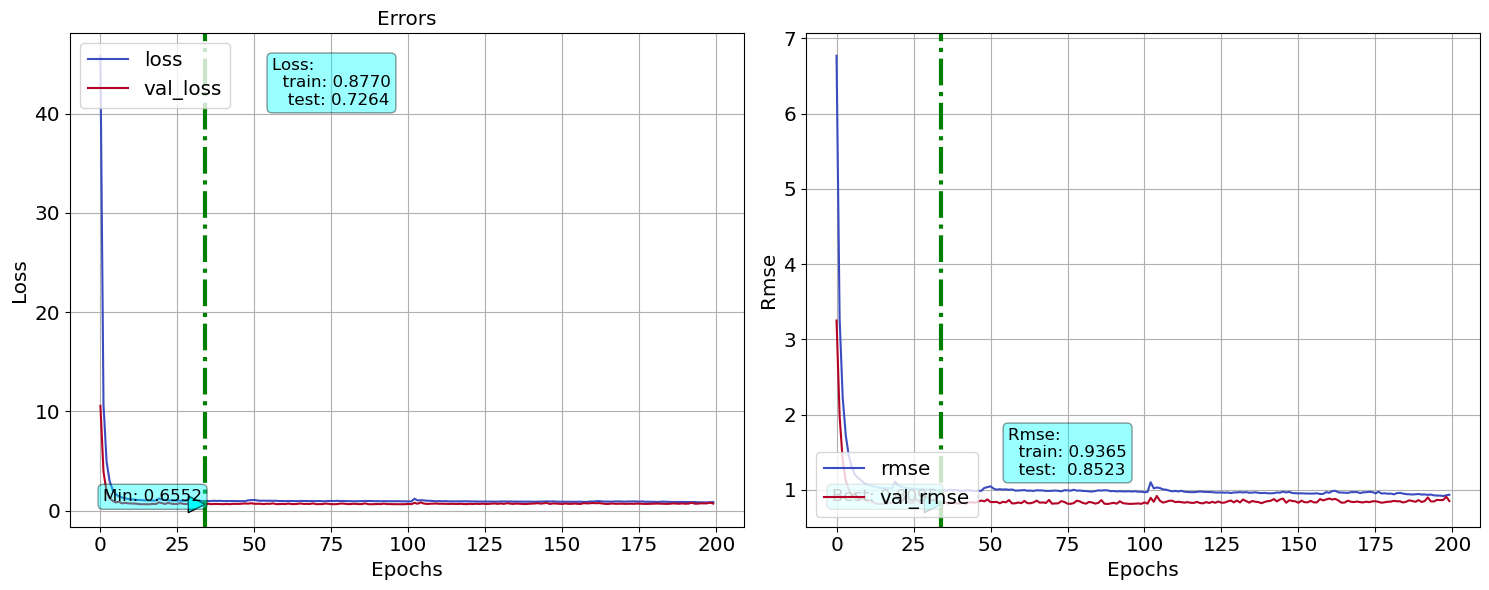

In [57]:
hist_df = pd.DataFrame(history.history)
hist_df = hist_df.rename({'root_mean_squared_error': 'rmse', 'val_root_mean_squared_error' : 'val_rmse'}, axis=1)


plot_tf_hist(hist_df)

In [58]:
# make predictions
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)
y_pred = np.append(y_train_pred, y_test_pred)

26/26 [==============================] - 0s 5ms/step


In [60]:
res_df = y_df.copy()
res_df['pred'] = y_pred
res_df['Time'] = res_df['Time'].dt.date
res_df.head()

Time      temp      pred
24   2006-01-01  5.422222  5.301651
48   2006-01-02  1.694444  1.640493
72   2006-01-03  2.200000  2.002794
96   2006-01-04  1.666667  1.913822
120  2006-01-05  1.805556  2.236354

In [61]:
res_df.tail()

Time      temp      pred
96336  2016-12-27 -1.627778 -1.226269
96360  2016-12-28 -1.677778 -1.379504
96384  2016-12-29 -1.727778 -1.548686
96408  2016-12-30 -1.777778 -1.689212
96432  2016-12-31 -1.822222 -1.776951

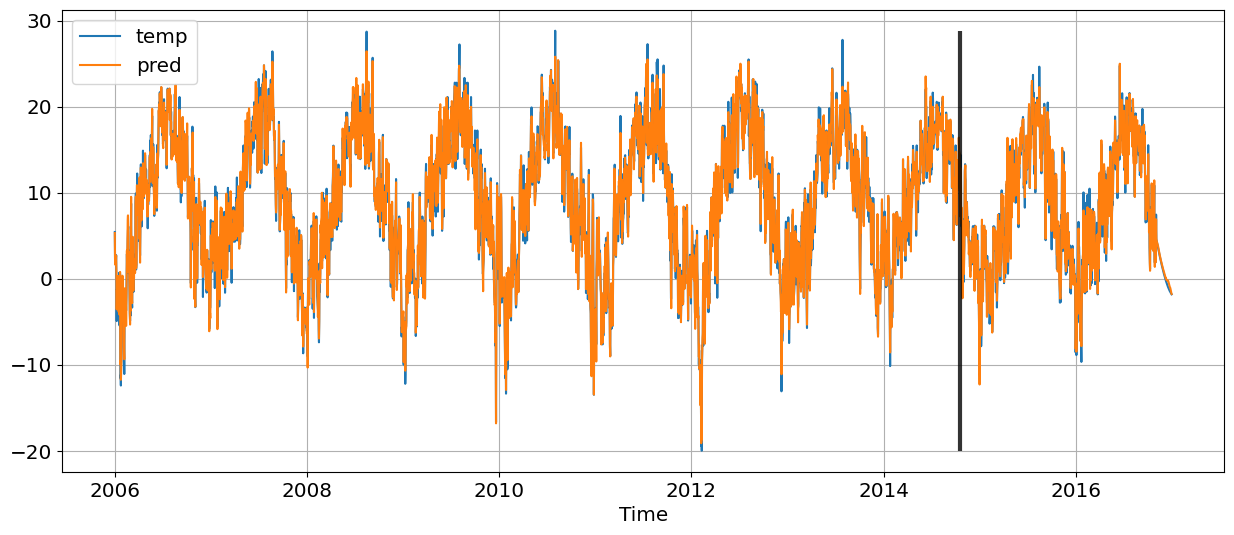

In [63]:
fig, ax = plt.subplots(figsize = (15,6))

res_df.plot(x='Time', y=['temp','pred'], ax = ax);

ax.vlines(res_df.iloc[X_train.shape[0]]['Time'], 
          res_df['temp'].min(), 
          res_df['temp'].max(), color = 'k', 
          linewidth=3.0, zorder=10, alpha =0.8)

ax.grid()